<a href="https://colab.research.google.com/github/ggossetl/fastbook/blob/master/MaskedFace_Net_29mar2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


     |████████████████████████████████| 727kB 8.1MB/s 
     |████████████████████████████████| 1.2MB 17.1MB/s 
     |████████████████████████████████| 194kB 36.5MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 12.8MB 203kB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
from pathlib import Path

In [4]:

path = Path('gdrive/MyDrive/MaskedFace-Net')

In [5]:
path.ls()

(#2) [Path('gdrive/MyDrive/MaskedFace-Net/CMFD'),Path('gdrive/MyDrive/MaskedFace-Net/IMFD')]

In [6]:
!ls

gdrive	sample_data


Setting-up type transforms pipelines
Found 1905 items
2 datasets of sizes 1524,381
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      gdrive/MyDrive/MaskedFace-Net/CMFD/01613_Mask.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=1024x1024
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      gdrive/MyDrive/MaskedFace-Net/CMFD/01613_Mask.jpg
    applying parent_label gives
      CMFD
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=1024x1024, TensorCategory(0))


Found 1905 items
2 datasets of sizes 1524,381
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipe

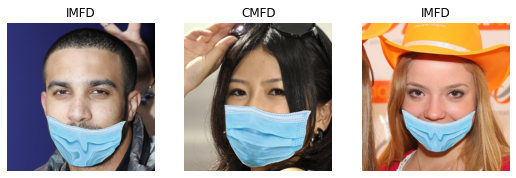

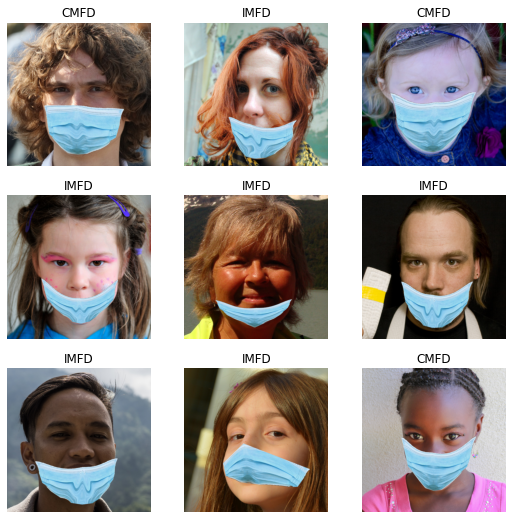

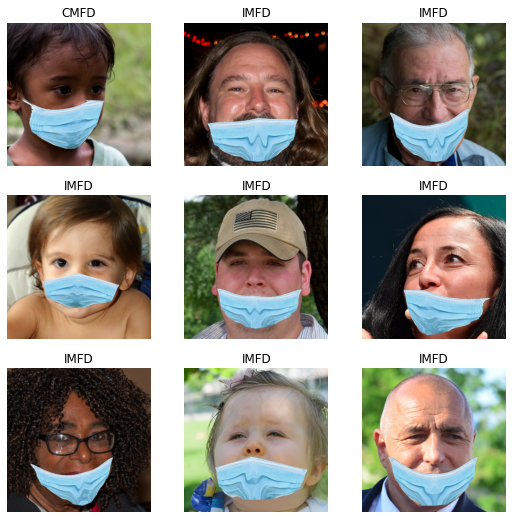

In [7]:
Face = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms = Resize(512))
dls = Face.dataloaders(path,bs=20)
dls.show_batch(nrows=1, ncols=3)
Face.summary(path)
dls.valid.show_batch()
dls.train.show_batch()


In [63]:
learn= cnn_learner(dls,resnet34, metrics=error_rate).to_fp16()
#learn.fine_tune(1, 1e-2).to_fp16()
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=3)
#learn.fit_one_cycle(2, 3e-3) 
#learn.unfreeze()
#learn.fit_one_cycle(1, lr_max=slice(1e-6,1e-4))


epoch,train_loss,valid_loss,error_rate,time
0,0.482725,0.221394,0.078740,01:01
1,0.226816,0.178256,0.068241,01:02
2,0.121458,0.129935,0.039370,01:02


epoch,train_loss,valid_loss,error_rate,time
0,0.067280,0.086957,0.031496,01:11
1,0.057616,0.007190,0.002625,01:12
2,0.019229,0.005930,0.002625,01:11


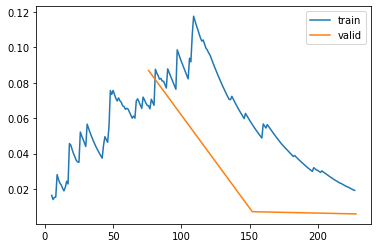

In [64]:
learn.recorder.plot_loss()

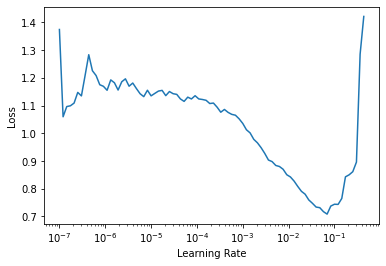

In [65]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
lr_min, lr_steep = learn.lr_find()

In [66]:
print(f"Minimum/10: {lr_min: .2e}, steepest point: {lr_steep: .2e}")

Minimum/10:  6.92e-03, steepest point:  6.31e-07


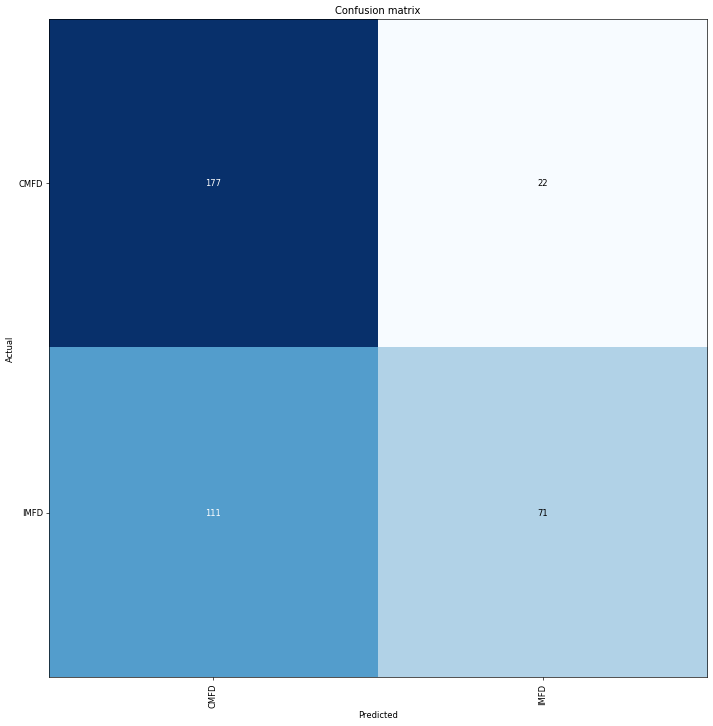

In [67]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

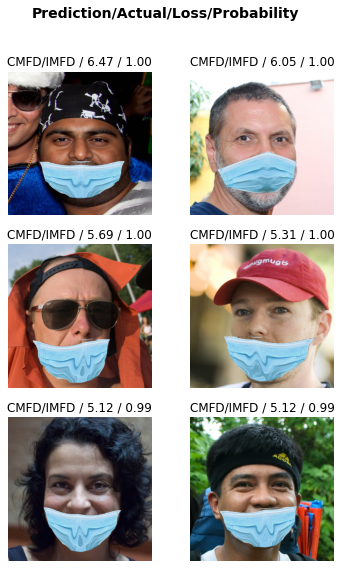

In [68]:
interp.plot_top_losses(6, nrows=3)



In [69]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')
learn_inf.dls.vocab

['CMFD', 'IMFD']

In [82]:

uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [83]:
img = PILImage.create(uploader.data[0])

In [84]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [85]:
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: CMFD; Probability: 0.9983')